This notebook illustrates how the entailment feature of the BERT model can be leveraged by the $R^3$ system to further narrow the results returned to the user - thus providing the reviews that are MOST relevant to the initial user query, irrespective of whether the reviews are glowing or critical.

The BERT model accepts 2 "segments" of text per sample, and was trained to classify whether the 2nd segment of text originally followed the 1st segment of text.  Here, we treat the user query as the 2nd segment and ask the BERT model to tell us how likely it is that the content of the query is addressed in the 1st segment. By returning the helpful reviews that have the very highest probability as output from BERT, we highlight only the most relevant reviews for the user.

Inspired and guided by the examples and code shared by Ceshine Lee at https://medium.com/the-artificial-impostor/news-topic-similarity-measure-using-pretrained-bert-model-1dbfe6a66f1d

In [1]:
!pip install pytorch_pretrained_bert

     |████████████████████████████████| 133kB 4.9MB/s 
     |████████████████████████████████| 655kB 42.4MB/s 
  Stored in directory: /root/.cache/pip/wheels/35/e4/80/abf3b33ba89cf65cd262af8a22a5a999cc28fbfabea6b38473
Successfully built regex


In [8]:
# For storage bucket access
!pip install gcsfs

In [0]:
# Alpha import list
from fastprogress import master_bar, progress_bar
import gcsfs
import json
import logging
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pprint
from pytorch_pretrained_bert.modeling import BertForNextSentencePrediction
from pytorch_pretrained_bert.tokenization import BertTokenizer
import random
from sklearn.model_selection import StratifiedShuffleSplit
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, SequentialSampler


In [0]:
# For reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

logging.basicConfig(format = '%(asctime)s - %(levelname)s - %(name)s -   %(message)s',
                    datefmt = '%m/%d/%Y %H:%M:%S',
                    level = logging.INFO)
logger = logging.getLogger("bert")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device == torch.device("cuda"):
    torch.cuda.manual_seed_all(SEED)
    
PYTORCH_PRETRAINED_BERT_CACHE = "/mnt/Intel/bert_tmp"


## Data Preparation & Query Sample

In [4]:
# Here's where I pull data from storage bucket (requires auth first time)
from google.colab import auth
auth.authenticate_user()
!gcloud config set project w266-239820


Updated property [core/project].


To take a quick anonymous survey, run:
  $ gcloud alpha survey



In [0]:
# As an example, the data for this notebook will be >1600 Amazon reviews
# all for the book Water for Elephants
my_data = "gs://w266/elephants.json"
elephants = pd.read_json(my_data,lines=True)

In [13]:
elephants.head()

,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
0,2007770,"[1, 1]",5,If I could rate higher it would be 10 stars. T...,"08 23, 2009",A3FVQCS5Q09W9N,"3dogs1cat ""3dogs1cat""",This book is awesome,1250985600
1,2007770,"[2, 2]",5,I really cannot understand the bad reviews. Th...,"01 16, 2012",A22019GDU7OVFG,"4fabfelines ""Lesa""","wow, amazing like you are there...very very good",1326672000
2,2007770,"[2, 3]",5,This book was absolutely wonderful. Two chapte...,"06 9, 2007",AKD68P643ZY8A,"AAH1234 ""AAH""",Amazing - Couldn't put it down!,1181347200
3,2007770,"[1, 1]",5,This story is one of the most entertaining I h...,"08 29, 2011",A3R7DVZHM6TR7X,"A. Bane ""Kindle Queen""",What a great story!!,1314576000
4,2007770,"[1, 1]",5,I don't typically buy books like this. I loved...,"04 25, 2013",AYUGFC7FOXDCF,AbbeyF,Not my thing...,1366848000


In [0]:
# Provide a sample user query, to be "answered" by relevant reviews 
sample_query = "good for a teenager headed off to veterinary school?"
size = elephants.shape[0]
q = pd.Series([sample_query])
q=q.repeat(size)

In [0]:
# Our input is 2 segments of text per review
my_sents = pd.DataFrame(np.vstack((elephants.reviewText.values, q.values)).transpose())
my_sents.rename(mapper={0:'reviews',1:'queries'},axis='columns',inplace=True)

In [0]:
class InputFeatures(object):
    """A single set of features of data."""

    def __init__(self, input_ids, input_mask, segment_ids, target):
        self.input_ids = input_ids
        self.input_mask = input_mask
        self.segment_ids = segment_ids
        self.target = target

In [0]:
def _truncate_seq_pair(tokens_a, tokens_b, max_length):
    """Truncates a sequence pair in place to the maximum length."""
    # This is a simple heuristic which will always truncate the longer sequence
    # one token at a time. This makes more sense than truncating an equal percent
    # of tokens from each, since if one sequence is very short then each token
    # that's truncated likely contains more information than a longer sequence.
    while True:
        total_length = len(tokens_a) + len(tokens_b)
        if total_length <= max_length:
            break
        if len(tokens_a) > len(tokens_b):
            tokens_a.pop()
        else:
            tokens_b.pop()

In [0]:
def convert_sentence_pair(reviews, queries, max_seq_length, tokenizer):
    features = []
    for (ex_index, (review, query)) in enumerate(zip(reviews, queries)):
        tokens_a = tokenizer.tokenize(review)

        tokens_b = None
        tokens_b = tokenizer.tokenize(query)
        # Modifies `tokens_a` and `tokens_b` in place so that the total
        # length is less than the specified length.
        # Account for [CLS], [SEP], [SEP] with "- 3"
        _truncate_seq_pair(tokens_a, tokens_b, max_seq_length - 3)

        # The convention in BERT is:
        # (a) For sequence pairs:
        #  tokens:   [CLS] is this jack ##son ##ville ? [SEP] no it is not . [SEP]
        #  type_ids: 0   0  0    0    0     0       0 0    1  1  1  1   1 1
        # (b) For single sequences:
        #  tokens:   [CLS] the dog is hairy . [SEP]
        #  type_ids: 0   0   0   0  0     0 0
        #
        # Where "type_ids" are used to indicate whether this is the first
        # sequence or the second sequence. The embedding vectors for `type=0` and
        # `type=1` were learned during pre-training and are added to the wordpiece
        # embedding vector (and position vector). This is not *strictly* necessary
        # since the [SEP] token unambigiously separates the sequences, but it makes
        # it easier for the model to learn the concept of sequences.
        #
        # For classification tasks, the first vector (corresponding to [CLS]) is
        # used as as the "sentence vector". Note that this only makes sense because
        # the entire model is fine-tuned.
        tokens = ["[CLS]"] + tokens_a + ["[SEP]"]
        segment_ids = [0] * len(tokens)

        if tokens_b:
            tokens += tokens_b + ["[SEP]"]
            segment_ids += [1] * (len(tokens_b) + 1)

        input_ids = tokenizer.convert_tokens_to_ids(tokens)

        # The mask has 1 for real tokens and 0 for padding tokens. Only real
        # tokens are attended to.
        input_mask = [1] * len(input_ids)

        # Zero-pad up to the sequence length.
        padding = [0] * (max_seq_length - len(input_ids))
        input_ids += padding
        input_mask += padding
        segment_ids += padding

        assert len(input_ids) == max_seq_length
        assert len(input_mask) == max_seq_length
        assert len(segment_ids) == max_seq_length

        if ex_index < 5:
            logger.info("*** Example ***")
            logger.info("tokens: %s" % " ".join(
                    [str(x) for x in tokens]))
            logger.info("input_ids: %s" % " ".join([str(x) for x in input_ids]))
            logger.info("input_mask: %s" % " ".join([str(x) for x in input_mask]))
            logger.info(
                    "segment_ids: %s" % " ".join([str(x) for x in segment_ids]))

        features.append(
                InputFeatures(
                    input_ids=input_ids,
                    input_mask=input_mask,
                    segment_ids=segment_ids,
                    target=1
        ))
    return features

In [23]:
tokenizer = BertTokenizer.from_pretrained(
    "bert-base-uncased", do_lower_case=True, 
    cache_dir=PYTORCH_PRETRAINED_BERT_CACHE)

07/28/2019 18:42:00 - INFO - pytorch_pretrained_bert.tokenization -   loading vocabulary file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt from cache at /mnt/Intel/bert_tmp/26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084


In [26]:
my_query_pairs = convert_sentence_pair(my_sents.reviews.tolist(), my_sents.queries.tolist(), max_seq_length=200, tokenizer=tokenizer)

07/28/2019 18:48:34 - INFO - bert -   *** Example ***
07/28/2019 18:48:34 - INFO - bert -   tokens: [CLS] if i could rate higher it would be 10 stars . the author did her research . the characters in this book seem so real . you will laugh , you will cry , you will feel hatred . you will cheer . you will be moved . [SEP] good for a teenager headed off to veterinary school ? [SEP]
07/28/2019 18:48:34 - INFO - bert -   input_ids: 101 2065 1045 2071 3446 3020 2009 2052 2022 2184 3340 1012 1996 3166 2106 2014 2470 1012 1996 3494 1999 2023 2338 4025 2061 2613 1012 2017 2097 4756 1010 2017 2097 5390 1010 2017 2097 2514 11150 1012 2017 2097 15138 1012 2017 2097 2022 2333 1012 102 2204 2005 1037 10563 3753 2125 2000 15651 2082 1029 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

## Show most relevant reviews


In [27]:
model = BertForNextSentencePrediction.from_pretrained(
    "bert-base-uncased",
    cache_dir=PYTORCH_PRETRAINED_BERT_CACHE
).to(device)

07/28/2019 18:48:43 - INFO - pytorch_pretrained_bert.file_utils -   https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased.tar.gz not found in cache, downloading to /tmp/tmpj4zdexok
100%|██████████| 407873900/407873900 [00:12<00:00, 33117922.04B/s]
07/28/2019 18:48:56 - INFO - pytorch_pretrained_bert.file_utils -   copying /tmp/tmpj4zdexok to cache at /mnt/Intel/bert_tmp/9c41111e2de84547a463fd39217199738d1e3deb72d4fec4399e6e241983c6f0.ae3cef932725ca7a30cdcb93fc6e09150a55e2a130ec7af63975a16c153ae2ba
07/28/2019 18:48:58 - INFO - pytorch_pretrained_bert.file_utils -   creating metadata file for /mnt/Intel/bert_tmp/9c41111e2de84547a463fd39217199738d1e3deb72d4fec4399e6e241983c6f0.ae3cef932725ca7a30cdcb93fc6e09150a55e2a130ec7af63975a16c153ae2ba
07/28/2019 18:48:58 - INFO - pytorch_pretrained_bert.file_utils -   removing temp file /tmp/tmpj4zdexok
07/28/2019 18:48:58 - INFO - pytorch_pretrained_bert.modeling -   loading archive file https://s3.amazonaws.com/models.huggingface.c

In [29]:
BATCH_SIZE = 128
logger.info("***** Running evaluation *****")

# TODO run predictions of relevance on ONLY the high-quality reviews 
# Don't waste computing power on reviews unlikely to be helpful
all_input_ids = torch.tensor([f.input_ids for f in my_query_pairs], dtype=torch.long)
all_input_mask = torch.tensor([f.input_mask for f in my_query_pairs], dtype=torch.long)
all_segment_ids = torch.tensor([f.segment_ids for f in my_query_pairs], dtype=torch.long)
eval_data = TensorDataset(all_input_ids, all_input_mask, all_segment_ids)


eval_sampler = SequentialSampler(eval_data)
eval_dataloader = DataLoader(eval_data, sampler=eval_sampler, batch_size=BATCH_SIZE)

logger.info("  Num examples = %d", len(my_query_pairs))
logger.info("  Batch size = %d", BATCH_SIZE)

model.eval()

res = []

mb = progress_bar(eval_dataloader)
for input_ids, input_mask, segment_ids in mb:
    input_ids = input_ids.to(device)
    input_mask = input_mask.to(device)
    segment_ids = segment_ids.to(device)

    with torch.no_grad():
        res.append(nn.functional.softmax(
            model(input_ids, segment_ids, input_mask), dim=1
        )[:, 0].detach().cpu().numpy())
        
res = np.concatenate(res)

07/28/2019 18:49:51 - INFO - bert -   ***** Running evaluation *****
07/28/2019 18:49:51 - INFO - bert -     Num examples = 1633
07/28/2019 18:49:51 - INFO - bert -     Batch size = 128


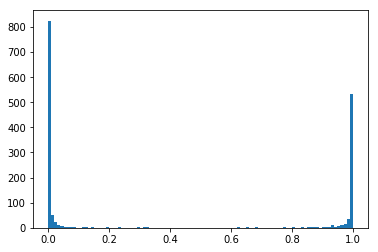

In [33]:
# We are culling out the reviews that have nothing to do with the query
_ = plt.hist(res, bins=100)


In [40]:
# Many reviews are highly unlikely to be related to the user query
# This approach ignores them altogether
# Meanwhile we return ONLY the reviews MOST likely to cover the user's query 
best_matches = np.argsort(res)[::-1][:10] 
only_the_best = list(my_sents.iloc[best_matches].reviews)
for review in range(len(only_the_best)):
  print(f"Review {review+1}")
  pprint.pprint(only_the_best[review])

Review 1
("'Water For Elephants' is one of those books that is so good it's hard to "
 'write down how deep your feelings for it are.  Jacob Jankowski is now ninety '
 'three years old and in an "assisted living" facility, when the circus comes '
 'to town.  This brings back startling memories of his early life, when his '
 'world fell apart and he found himself on a circus train heading into his '
 'future.On the brink of passing his final exams for veterinary school, Jacob '
 'is informed that his parents have just died in an automobile accident.  '
 'Adding insult to injury, their house and practice were mortgaged to pay for '
 "his school and there's nothing left for Jacob.  He walks out of his final "
 'exam and keeps walking, until finding himself beside a railroad track.  '
 "Jumping the next train, he later realizes it's a circus train.  An old man "
 'named Camel helps him out, and gets him hired on with the show as the '
 'veterinarian.Jacob winds out bunking with a recalcitr